### load requred packages and pre-computed simulations and data-matched parameters

In [2]:
homedir <- '/Users/chenlingantelope/ResearchProjects/scRNA_simulation/'
setwd(homedir)
required_packages <- c('devtools','FNN','reshape','ggplot2','gridExtra','ape','MASS','Rtsne','RColorBrewer','fAsianOptions','fOptions','fBasics','timeSeries','timeDate','Biobase','repr' )
install_packages <- rownames(installed.packages())
need_install <- setdiff(required_packages,install_packages)
if(length(need_install)>0){install.packages(need_install)}

load_result <- lapply(required_packages, require, character.only = TRUE)

load('allsim.20170706.robj')
load('match_params.robj')


### load package SCsim and set up plotting size in jupyter

In [46]:
load_all('SCsimR')
options(repr.plot.width=5, repr.plot.height=4)
ngenes=1000
ncells=1000
nevf=10
randseed=0

Loading SCsim


# Overview
The input parameters of the package allow users to control intrinsic variation, technical variation and biological variation in the data. Intrinsic variation is modeled through the kinetic model; technical variation takes into account dropouts, batch effects, GC and length biases of genes; and biological variation is modeled by EVFs (extrinsic variation factors). 

**sim1Pop1Batch** is the main function in the SCsim package. It takes all of the parameters needed for generating the count matrix for a homogeneous population that is sequenced in 1 batch.

 The input parameters are listed below while being categorized by the level of variation they contribute to:

Parameters that affect intrinsic variation:
* **bimod** the proportion of distance to move a point in the kon-koff space towards the center of the kon-koff space where the gene expression is bimodal

Parameters that affect technical variation:
* **alpha** library prep capture efficiency, or dropout of transcript: the number of of captured transcript is distributed as the number of successes with probability of success alpha in X trials, where X is the true number of transcripts
* **alpha_sd** the standard deviation of alpha (to add noise for different efficiency for each cell)
* **nbins** the number of bins for gc and length bias
* **gcbias** the magnitude of gc bias (a number between 0 and 2) 
* **lenbias** the magnitude of length bias (a number between 0 and 2)
* **batch_mean** The mean batch effect from which the batch effect of each gene is sampled from
* **batch_sd** The standard deviation of batch effect from which the batch effect of each gene is sampled from
* **noise** the standard deviation of a normal distribution where the log(noise) is sampled from
* **randseed** the random seed to generate the gc and length bins (should keep constant for each experiment regardless of the batch and population, but should change for replicates of simulations)

Parameters that affect biological variation:
* **evf_mean** a vector of length nevf, the means of the normal distribution to sample EVF from 
* **evf_sd** a vector of length nevf, the standard deviation of the normal distribution to sample EVF from
* **gene_effects** a matrix of ngenes * nevf, generated by GeneEffects function

Other parameters: 
* **ncells** number of cells to simulate

# Prepare input parameters: Compute gene effects 
The gene effect is a matrix of ngenes*nevf, generated by GeneEffects function and remains the same across all experiments. Its role is explained in the **evf** section of this document

In [47]:
gene_effects <- GeneEffects(ngenes=ngenes,nevf=10,randseed=0,sd=1,prob=0.3)

# Simulation: an example run 
We will simulate a dataset using the sim1Pop1Batch and visualize the results with function PlotCountHeatmap. The output of the sim1Pop1Batch function is a list of sampled EVF for each cell, and transcript count matrices that have different levels of noise added to it. In the follwing example, temp is the output of the funcion. temp[[1]] is a list of **evf** for each cell, temp[[2]] is the true transcript counts directly sampled from the stationary distribution given expression dynamic parameters, temp[[3]] is after dropout, and temp[[4]] is the dropped out counts plus batch effects and gene-specific biases.

In [48]:
temp<-sim1Pop1Batch(evf_mean=rep(1,nevf), evf_sd=rep(0.2,nevf),ncells=ncells,
        randseed=0,gene_effects=gene_effects,bimod=0.1,alpha=0.1,
        alpha_sd=0.01,nbins=10,gcbias=0.1,lenbias=0.1,batch=exp(rnorm(ngenes,0,0.1)),noise=0.1,
        matched_params=match_params1)
log_count_bins<-seq(0,4,0.4)
head(do.call(rbind,temp[[1]]))
ord1<-PlotCountHeatmap(LogDist(temp[[2]],log_count_bins),rowMeans(temp[[2]]),NA,1,paste('truecounts.bimod=',bimod,'.jpeg',sep=''))
ord2<-PlotCountHeatmap(LogDist(temp[[3]],log_count_bins),rowMeans(temp[[3]]),NA,1,paste('droppedcounts.bimod=',bimod,'.jpeg',sep=''))
ord3<-PlotCountHeatmap(LogDist(temp[[4]],log_count_bins),rowMeans(temp[[4]]),NA,1,paste('biasedcounts.bimod=',bimod,'.jpeg',sep=''))


1.2866900,0.9449861,0.8414142,0.9123662,1.3288666,0.8892847,1.1626768,0.7026957,1.052931,1.1382719
1.1316222,1.2266556,0.6628612,1.3662893,0.8363478,0.9102919,0.9656909,1.3739272,1.079063,1.0579053
0.5642338,1.1332739,0.9214946,0.9054796,1.2790732,1.2707864,1.2697303,0.9362074,0.913490,0.6477116
1.1468206,0.7281305,0.7606892,1.0670305,0.7189238,1.0030201,0.8462992,1.0009931,1.246049,0.9783061
1.0063674,1.0785702,0.8646135,0.8576106,1.2024718,1.1659070,1.0321968,0.7340693,1.219873,0.9830534
1.1099424,1.1323607,1.3299193,1.0694281,0.9212295,0.6838647,0.9026446,1.1787594,1.021415,1.1811892


# Look at FNR curves of the test run

[1] 108

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

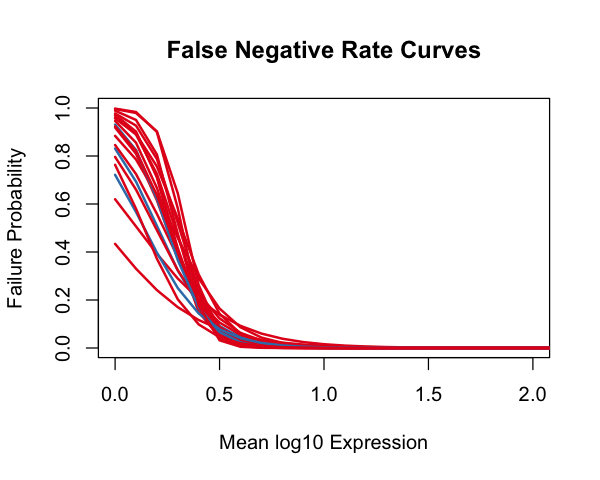

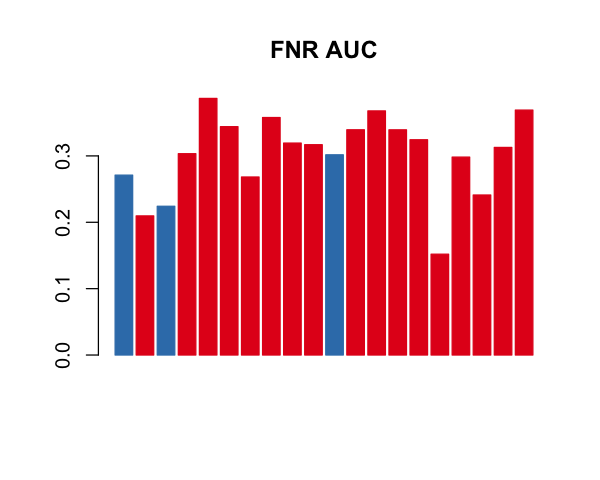

In [82]:
## library(RColorBrewer)
cc <- c(brewer.pal(9, "Set1"))
library('scone', character.only = TRUE)
counts=temp[[4]]
# filter out cells where less than 10% of all genes are expressed
notzero <- apply(counts,2,function(X){sum(X>0)>length(X)*0.1})
counts<-counts[,notzero]

# home keeping gene is defined as genes that are in the top half highest expressed genes
# taht are also in the top half lowest variance genes
highexprs <- c(1:length(counts[,1]))[rowMeans(counts)>quantile(rowMeans(counts),0.5)]
sd2 <- apply(counts,1,var)
lowvar <- c(1:length(counts[,1]))[sd2/rowMeans(counts)<quantile(sd2/rowMeans(counts),0.5,na.rm=T)]
hk <- intersect(highexprs,lowvar)
# check that there is enough of them
length(hk)

## ----fnr_fit-------------------------------------------------------------
# Mean log10(x+1) expression
mu_obs = rowMeans(log10(counts[hk,]+1))

# Assumed False Negatives
drop_outs = (counts[hk,] == 0)

# Logistic Regression Model of Failure
ref.glms = list()
for (si in 1:dim(drop_outs)[2]){
  fit = glm(cbind(drop_outs[,si],1 - drop_outs[,si]) ~ mu_obs,
            family=binomial(logit))
  ref.glms[[si]] = fit$coefficients
}


## ----fnr_vis,fig.width=8,fig.height=4,out.width="800px",out.height="400px"----
# Plot Failure Curves and Calculate AUC
plot(NULL, main = "False Negative Rate Curves",
     ylim = c(0,1),xlim = c(0,2), 
     ylab = "Failure Probability", xlab = "Mean log10 Expression")
x = (0:60)/10
AUC = NULL
for(si in 1:20){
  y = 1/(exp(-ref.glms[[si]][1] - ref.glms[[si]][2] * x) + 1)
  AUC[si] = sum(y)/10
  lines(x, 1/(exp(-ref.glms[[si]][1] - ref.glms[[si]][2] * x) + 1),
        type = 'l', lwd = 2, col = cc[batch][si])
}

# Barplot of FNR AUC
o = order(AUC)[order(batch[order(AUC)])]

barplot(AUC[o], col=cc[batch][o], border=cc[batch][o], main="FNR AUC")


In [ ]:
library(RColorBrewer)
colfunc <- colorRampPalette(c("blue", "green", "red", "purple"))
allcol <- colfunc(2000)

par(mfrow=c(1,2))
shared_genes_ss2 <- intersect(intersect(rownames(ss2_130cells_tpm), expressed_genes_ss2$Gene), 
                              names(mm10_gene_length))

data_name <- "ss2"
expr_matrix <- ss2_130cells_tpm[shared_genes_ss2, ]
cv_vec <- apply(expr_matrix, 1, sd(x)/mean(x))
mean_vec <- rowMeans(log2(expr_matrix+1))
hk <- names(which(mean_vec > 5 & cv_vec < 0.7)) # for ss2
col_vec_ss2 <- allcol[round(rescale2range(colSums(countTable[
  shared_genes_ss2, colnames(ss2_130cells_tpm)]), 2000))]
plotFNR(expr_matrix, hk, data_name, col_vec_ss2)

# Test the effect of parameters on changing various levels of variation
## The intrinsic variation from the stochastic nature of gene expression
We use a kinetic gene expression model that assumes that a gene switches between an 'on' state and an 'off' state. The rate of turning on is $k_{on}$ and the rate of turning off is $k_{off}$. Transcripts are synthesized at rate $s$ when the gene is on. They also degrade at rate $d$ regardless of the state. From these four parameters we can calculate the stationary distribution of the abundance of each transcript in each cell. The first variation that we simulate is this intrinsic variation, which means that even when expression is governed by exactly the same parameters (or as we will refer to it, the cells sharing the same parameters are in the same population), cells might have different transcript counts. The amount of variation can be tuned by changing the parameter range. 

We give each gene in the same population the same $k_{on}$, $k_{off}$, $s$ and $d$ ($d$ is always 1) with some noise added for each cell. We noticed that the expression distribution tend to be bimodal, and has high variation when $k_{on}$ and $k_{off}$ are very small, as shown on the heatmap below. The first plot shows how the fano factor increases at the bottom left corner when $s=10$. To increase the intrinsic variation we can vary the bimod, or $\beta$ parameter so that the $k_{on}$ and $k_{off}$ parameter is closer to the bottom left corner within the region of bimodal distribution (purple clolor in the second plot, where the value 2 indicates that the distribution has 2 inflection points). Note that the axis are on log scale. 

In [6]:
source('SCsimR/MasterEqnLookup.funcs.R')
load('SCsimR/Simulation_DistFeatures.20170706.robj')
dist_features<-dist_features[dist_features[,3]==10,]
fano_plot <- MasterEqn_heatmap(Fano,dist_features,'20170706.MasterEqn_Fano_Heatmap.pdf','Fano Factor','log')
mean_plot <- MasterEqn_heatmap(Diptest,dist_features,'20170706.MasterEqn_Diptest_Heatmap.pdf','number of inflections','identity')


### The effect of changing beta on parameter distribution
The paramete bimod, or $\beta$ can be set to a value from 0 to 1. 0 means that we keep the original $k_{on}$ and $k_{off}$. Any value above 0 means that we move the original $k_{on}$ and $k_{off}$ closer to the center of bimodality ($k_{on}=-1$ and $k_{off}=-0.5$) by $\beta$ the distance between the center and the original point. When $beta$ is set to 1, then all of the $k_{on}$ and $k_{off}$ have value $-1,-0.5$. You could experiment with the effect of $\beta$ by chaning the value of bimod in the next cell and see the distribution of $k_{on}$, $k_{off}$ and $s$ for different values of $\beta$

In [7]:
bimod <-0.8
evf_mean<-rep(0,10)
evf_sd<-rep(0.1,10)
evfs <- lapply(c(1:ncells),function(celli){
	evf <- sapply(c(1:length(evf_mean)),function(evfi){rnorm(1,evf_mean[evfi],evf_sd[evfi])})
	return(evf)
})

params<-lapply(c(1:ncells),function(i){Get_params(gene_effects,evfs[[i]],match_params1,bimod)})
param1<-do.call(rbind,lapply(params,function(X){X[1,]}))
PlotParamHist(param1,paste('beta=',bimod,'.1',sep=''))


Using  as id variables


TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

### The effect of changing beta on gene expression distributions
After sampling the kinetic parameters for each gene, we can now simulate the gene expression matrix with the bimodality parameter, using the function sim1Pop1Batch. There are many other parameters in the function that we will introduce later. We can visualize the expression matrix using a 2D histogram with the function PlotCountHeatmap.  

We can visualize the expression matrix using a 2D histogram with the function PlotCountHeatmap.  

In [8]:
bimod <-0.9
temp<-sim1Pop1Batch(evf_mean=rep(1,nevf), evf_sd=rep(0.2,nevf),ncells=ncells,
        randseed=randseed,gene_effects=gene_effects,bimod=bimod,alpha=0.1,
        alpha_sd=0.01,nbins=10,gcbias=0.1,lenbias=0.1,batch=exp(rnorm(ngenes,0,0.1)),noise=0.1,
        matched_params=match_params1)
log_count_bins<-seq(0,4,0.4)
#ord1<-PlotCountHeatmap(LogDist(temp[[2]],log_count_bins),rowMeans(temp[[2]]),NA,1,paste('truecounts.bimod=',bimod,'.jpeg',sep=''))
#ord2<-PlotCountHeatmap(LogDist(temp[[3]],log_count_bins),rowMeans(temp[[3]]),NA,1,paste('droppedcounts.bimod=',bimod,'.jpeg',sep=''))
#ord3<-PlotCountHeatmap(LogDist(temp[[4]],log_count_bins),rowMeans(temp[[4]]),NA,1,paste('biasedcounts.bimod=',bimod,'.jpeg',sep=''))


### The effect of changing beta on gene expression fano factor 
To do a more systematic comparision we will perform simulations with 10 different $\beta$ values. 

In [9]:
change_bimod <- lapply(seq(0,1,0.1),function(bimod){
    start <- proc.time()
	temp<-sim1Pop1Batch(evf_mean=rep(1,nevf), evf_sd=rep(0.1,nevf),ncells=ncells,
			randseed=randseed,gene_effects=gene_effects,bimod=bimod,alpha=0.1,
			alpha_sd=0.01,nbins=10,gcbias=0.1,lenbias=0.1,batch=exp(rnorm(ngenes,0,0.3)),noise=0.1,
			matched_params=match_params1)
    #print(proc.time()-start)
	return(temp)
})

And compare the fano factor of gene expression when bimod increases. We see that as we artificially increase the amount of bimodality the fano factor increases. 

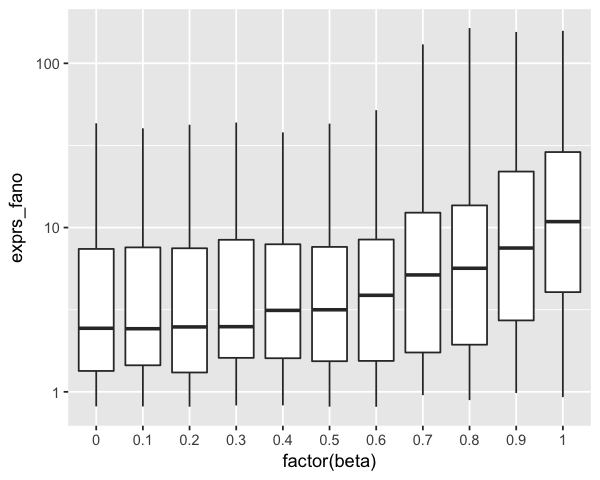

In [10]:
fano_compare <- lapply(change_bimod,function(X){apply((X[[2]]),1,function(Y){var(Y)/mean(Y)})})
fano_compare <- do.call(rbind,fano_compare)
rownames(fano_compare)<-seq(0,1,0.1)
df<-melt(fano_compare)
colnames(df)=c('beta','rep','exprs_fano')
p <- ggplot(df, aes(x=factor(beta), y=exprs_fano))
p <- p + geom_boxplot()+ scale_y_continuous(trans='log10')
p

## The technical variation #1: dropout (cell specific)

After obtaining the true count matrix, we need to simulate the dropout process where not all of the transcripts are presented in the library. For a simple approximation we model the number of transcripts from a gene in a library as a binomial sampling process, where the number of trials is the number of transcripts of the same gene, and each transcript has probability $\alpha$ of being sampled. 
To make the simulation more realistic, the $\alpha$ parameter is not the same for every cell, but is sampled from a normal distribution centered at $\alpha$, with standard deviation $alpha_sd$. The final distribution is truncated at 0 and 1 because probability must be between 0 & 1. 
The following plot shows the expression matrix before and after $\alpha=0.1$ was added. 

In [11]:
ord1<-PlotCountHeatmap(LogDist(temp[[2]],log_count_bins),rowMeans(temp[[2]]),NA,1,paste('truecounts.bimod=',bimod,'.jpeg',sep=''))
ord2<-PlotCountHeatmap(LogDist(temp[[3]],log_count_bins),rowMeans(temp[[3]]),NA,1,paste('droppedcounts.bimod=',bimod,'.jpeg',sep=''))


In [12]:
change_alpha <- lapply(seq(0,1,0.1),function(alpha){
    TrueCounts2Dropped(temp[[2]],alpha,alpha_sd=0.1)
})

### The effect of $\alpha$ on the mean and fano factor of the gene expressions. 

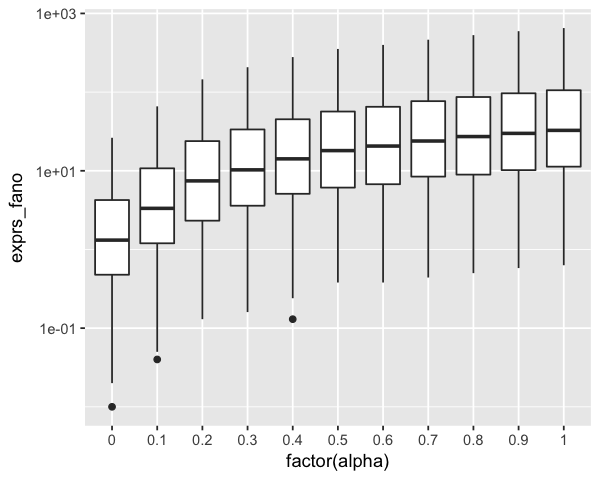

In [13]:
mean_compare <- lapply(change_alpha,function(X){rowMeans(X)})
mean_compare <- do.call(rbind,mean_compare)
rownames(mean_compare)<-seq(0,1,0.1)
df<-melt(mean_compare)
colnames(df)=c('alpha','rep','exprs_fano')
p <- ggplot(df, aes(x=factor(alpha), y=exprs_fano))
p <- p + geom_boxplot()+ scale_y_continuous(trans='log10')
p

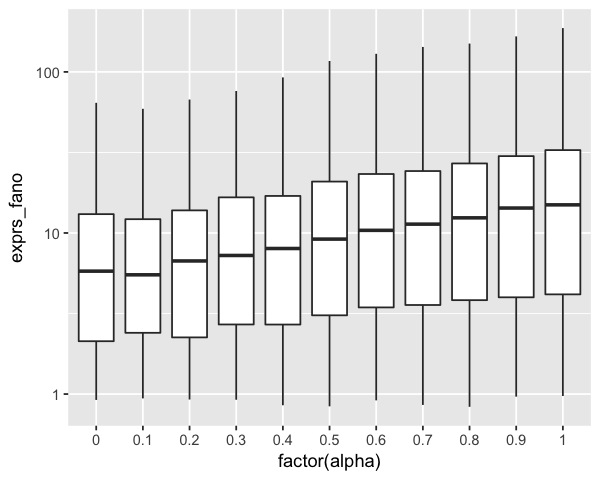

In [14]:
fano_compare <- lapply(change_alpha,function(X){apply((X),1,function(Y){var(Y)/mean(Y)})})
fano_compare <- do.call(rbind,fano_compare)
rownames(fano_compare)<-seq(0,1,0.1)
df<-melt(fano_compare)
colnames(df)=c('alpha','rep','exprs_fano')
p <- ggplot(df, aes(x=factor(alpha), y=exprs_fano))
p <- p + geom_boxplot()+ scale_y_continuous(trans='log10')
p

# Technical variation #2 $\lambda$: batch effects, GC and length bias, noise (gene and batch specific)
We model the bias and batch effect by multiplying the dropped count matrix by four vectors of length number of genes.
* gc bias(all genes in the same gc bin is multipled by a factor according to their bin. Higher gc content is biased towards higher expression) 
* length bias (all genes in the same length bin is multipled by a factor according to their bin. Longer genes are biased towards lower expression)  
* batch (noise that is sampled for each gene but is the same for all cells in the same batch)
* jiggle (simple noise that is sampled for every gene in every cell independently)


**notes**: genes are randomly assigned to a length or gc bin: but as long as the parameter randseed and number of genes do not change, the same genes are assigned to the same bins everytime. So in practice the trends of gc and length bin do not matter. 

### gc and length bias

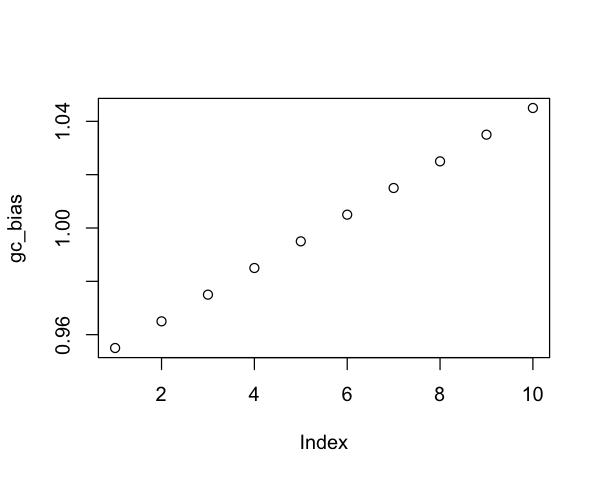

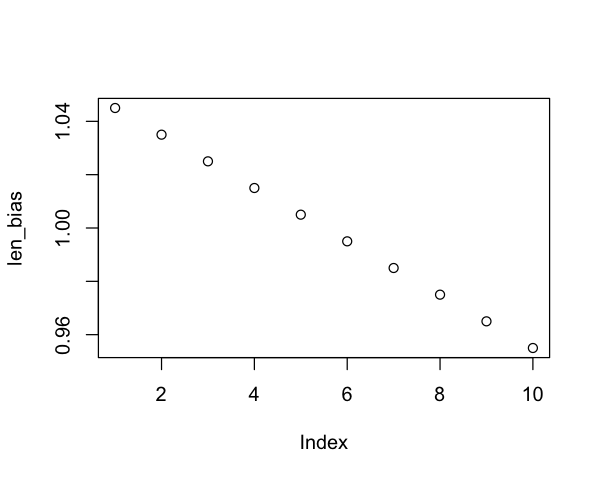

In [15]:
gcslope <-0.1;lenslope<-(0.1);nbins=10
gcslope <- gcslope/nbins; lenslope <- lenslope/nbins
gc_bias <- c(1:nbins)*gcslope
gc_bias<-(gc_bias+(1-median(gc_bias)))[c(1:nbins)]
len_bias <- (-c(1:nbins))*lenslope
len_bias<-(len_bias+(1-median(len_bias)))[c(1:nbins)]
plot(gc_bias)
plot(len_bias)

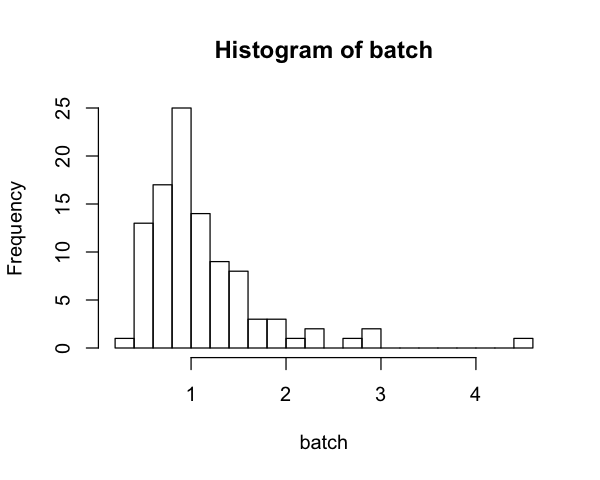

In [16]:
batch <-0.5
batch <- exp(rnorm(ngenes,mean=0,sd=batch))
hist(batch,20)

**The code to generate the new count matrix with the dropped count matrix is the following**
```R
biased_exprs <- apply(dropped_exprs,2,function(X){
    jiggle <- rnorm(length(X),mean=0,sd=epsilon)
    Y <- X * gc_bias * len_bias * batch * exp(jiggle)
    return(Y)
})
```

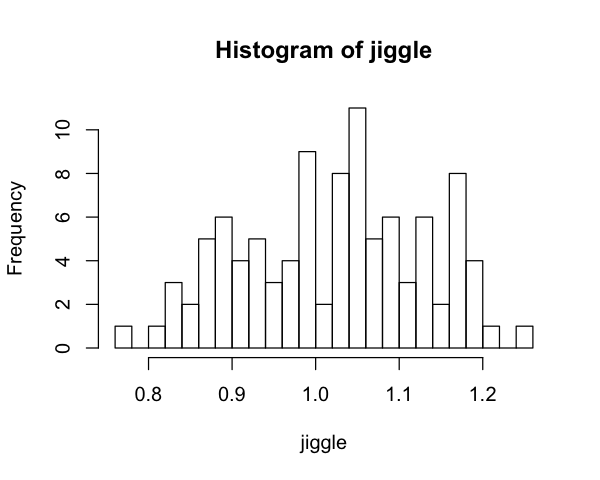

In [17]:
noise<-0.1
jiggle <- exp(rnorm(ngenes,mean=0,sd=noise))
hist(jiggle,20)

We can visualize how the count matrix change with the following paramters
 * gcbias=0.1
 * lenbias=0.1
 * batch=exp(rnorm(ngenes,0,0.1))
 * noise=0.1

In [18]:
ord1<-PlotCountHeatmap(LogDist(temp[[3]],log_count_bins),rowMeans(temp[[2]]),NA,1,'')
ord2<-PlotCountHeatmap(LogDist(temp[[4]],log_count_bins),rowMeans(temp[[3]]),NA,1,'')


# Extrinsic Variation $\sigma$
We use a cell specific vector that we term **evf**, or extrinsic variation factor to model the cellular state or environmental factors that affect the kinetic parameters of gene expression. It has length $nevf$. Each element in the **evf** vector is sampled independently. Each kinetic parameter for each gene has its own $gene\_effect$ vector of length $nevf$. Its value is determined by a function $f$ of the dot product $x_{i,j} = evf_i * gene\_effect_j$. The role of the function $f$ is to transform the dot product $x$ to the correct paramter range and give a distribution of parameter that is close to the experimentally fitted distribution of the kinetic paramters. 

## Sampling evf

**evf** is sampled from a normal distribution of mean $evf\_mean$ and standard deviation $\sigma$. The cells in the same population share the same $evf\_mean$ but will have more similar sampled **evf** is sigma is small. We can explore the effect of sigma on the distribution of $k_{on}$, $k_{off}$ and $s$ for a random gene by looking at the histogram distribution of $k_{on}$, $k_{off}$ and $s$ after altering the **Sigma** value in the following code block. 

In [19]:
Sigma<-0.2
evf_mean<-rep(0,10)
evf_sd<-rep(Sigma,10)
evfs <- lapply(c(1:ncells),function(celli){
	evf <- sapply(c(1:length(evf_mean)),function(evfi){rnorm(1,evf_mean[evfi],evf_sd[evfi])})
	return(evf)
})
params<-lapply(c(1:ncells),function(i){Get_params(gene_effects,evfs[[i]],match_params1,0)})
param1<-do.call(rbind,lapply(params,function(X){X[1,]}))
PlotParamHist(param1,'temp')

Using  as id variables


TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

Similarly, we can explore effect of sigma on the distribution of gene expression for all genes in a homogeneous population by visualizing the gene expression heatmap

The three plots correspond to 
* true counts
* sampled counts (sampled binomially with probability $\alpha$)
* biased counts (sampled binomially with probability $\alpha$, and added the gene and batch specific bias term $\lambda$)

In [20]:
Sigma<-0.2
#start <- proc.time()
temp<-sim1Pop1Batch(evf_mean=rep(1,nevf), evf_sd=rep(Sigma,nevf),ncells=ncells,
    randseed=randseed,gene_effects=gene_effects,bimod=0,alpha=0.1,
    alpha_sd=0.01,nbins=10,gcbias=0.5,lenbias=0.3,batch=exp(rnorm(ngenes,0,0.3)),noise=0.1,
    matched_params=match_params1)
#print(proc.time()-start)
log_count_bins<-seq(0,4,0.4)
ord1<-PlotCountHeatmap(LogDist(temp[[2]],log_count_bins),rowMeans(temp[[2]]),NA,0.9,paste('truecounts.sigma=',Sigma,'.jpeg'))
ord2<-PlotCountHeatmap(LogDist(temp[[3]],log_count_bins),rowMeans(temp[[3]]),NA,0.9,paste('droppedcounts.sigma=',Sigma,'.jpeg'))
ord3<-PlotCountHeatmap(LogDist(temp[[4]],log_count_bins),rowMeans(temp[[4]]),NA,0.9,paste('biasedcounts.sigma=',Sigma,'.jpeg'))



We can simulate populations of cells of different **Sigma** values

In [21]:
change_sigma <- lapply(seq(0.1,1,0.1),function(Sigma){
    #start <- proc.time()
	temp<-sim1Pop1Batch(evf_mean=rep(1,nevf), evf_sd=rep(Sigma,nevf),ncells=ncells,
			randseed=randseed,gene_effects=gene_effects,bimod=0,alpha=0.1,
			alpha_sd=0.01,nbins=10,gcbias=0.5,lenbias=0.3,batch=exp(rnorm(ngenes,0,0.3)),noise=0.1,
			matched_params=match_params1)
    #print(proc.time()-start)
	return(temp)
})

And look at how sigma affects the fano factor and mean expression by the box plot where y axis is the expression fano factor on log scale, and x axis is the sigma value used. We expect the mean to be unaffected and the fano factor to increase as we increase the **Sigma** value

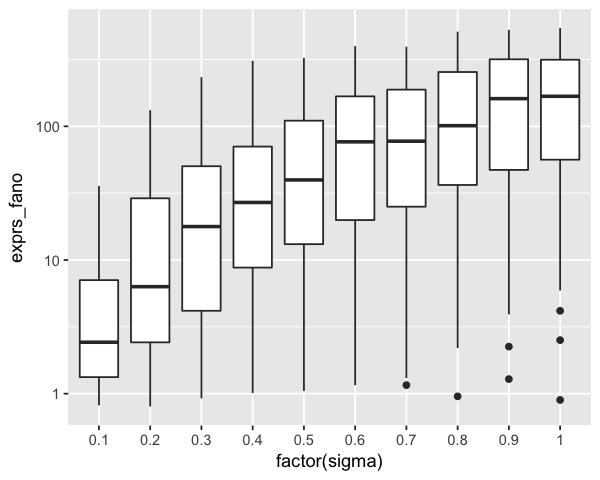

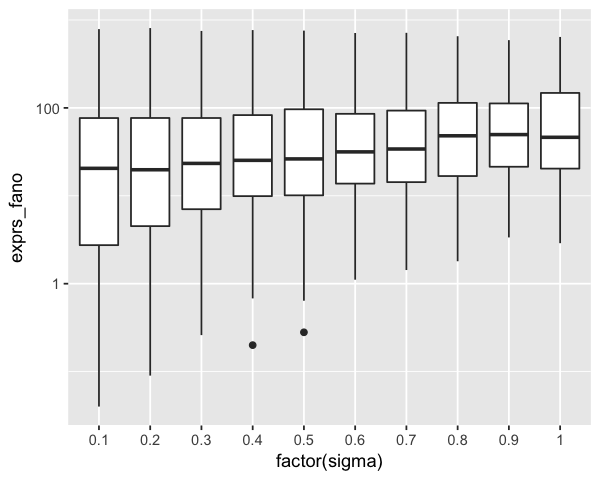

In [22]:
fano_compare <- lapply(change_sigma,function(X){apply((X[[2]]),1,function(Y){var(Y)/mean(Y)})})
fano_compare <- do.call(rbind,fano_compare)
rownames(fano_compare)<-seq(0.1,1,0.1)
df<-melt(fano_compare)
colnames(df)=c('sigma','rep','exprs_fano')
p <- ggplot(df, aes(x=factor(sigma), y=exprs_fano))
p <- p + geom_boxplot()+ scale_y_continuous(trans='log10')
print(p)

mean_compare <- lapply(change_sigma,function(X){apply((X[[2]]),1,function(Y){mean(Y)})})
mean_compare <- do.call(rbind,mean_compare)
rownames(mean_compare)<-seq(0.1,1,0.1)
df<-melt(mean_compare)
colnames(df)=c('sigma','rep','exprs_fano')
p <- ggplot(df, aes(x=factor(sigma), y=exprs_fano))
p <- p + geom_boxplot()+ scale_y_continuous(trans='log10')
print(p)



# Simulating evf from multiple discrete populations
We model discrete populations that are related to each other in a tree structure. We first randomly generate a tree, assume that each discrete population is sampled from the leave of the tree. Thus their *evf_mean* should be related to each other by a variance-covariance matrix corresponding to distances between leave nodes. We first visualize the topology of the tree and the variance-covariance matrix that correspond to the distances in the tree

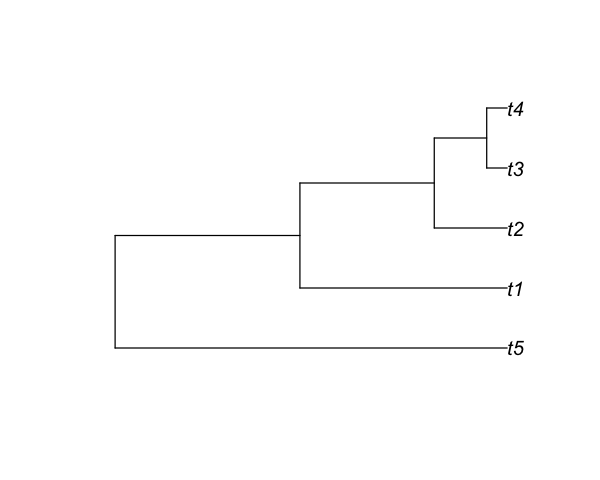

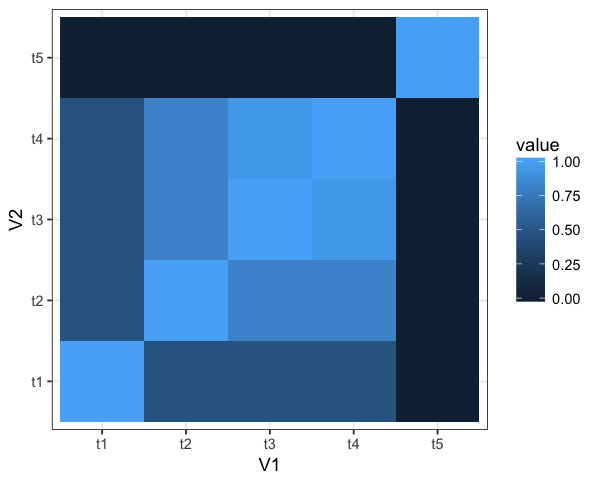

In [23]:
phyla<-rcoal(5)
plot(phyla)
cor_evf_mean<-vcv.phylo(phyla,cor=T)
varplot<-melt(cor_evf_mean)
varplot$V1<- factor( varplot$X1, levels = phyla$tip.label[order(cor_evf_mean[,1])])
varplot$V2<- factor( varplot$X2, levels = phyla$tip.label[order(cor_evf_mean[1,])])
ggplot(data=varplot,aes(x=V1, y=V2, fill=value)) + geom_tile() + theme_bw()

We can then sample **evf_mean** from a multivariate normal distribution centered around 0 with the variance-covariance matrix obtained from the tree, and visualize if given the number of evfs and the tree structure, the experimental variance-covariance matrix of the **evf_mean** still is similar to the theoretical one.

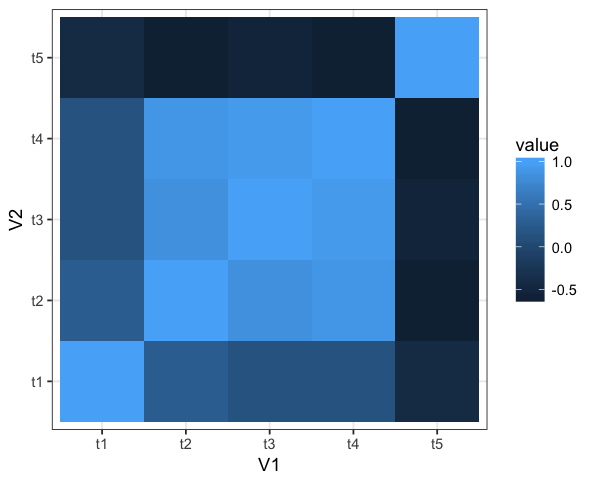

In [24]:
pop_evf_mean<-mvrnorm(nevf,rep(0,5),cor_evf_mean)
cor_evf_mean_exp <- cor(pop_evf_mean)
varplot<-melt(cor_evf_mean_exp)
varplot$V1<- factor( varplot$X1, levels = phyla$tip.label[order(cor_evf_mean[,1])])
varplot$V2<- factor( varplot$X2, levels = phyla$tip.label[order(cor_evf_mean[1,])])
ggplot(data=varplot,aes(x=V1, y=V2, fill=value)) + geom_tile() + theme_bw()

**Npop1Batch** is a wrapper around the function **sim1Pop1Batch**  that generate **evf_mean** according to the input tree structure. It then samples **evf** vectors for each cell and then use the **sim1Pop1Batch** to generate data sampled from multiple populations but within the same  batch$\lambda$. 

The parameters for **Npop1Batch** is only different from the **sim1Pop1Batch** by 
* it takes a tree as an input and generate $evf\_mean$, instead of a constant for the $evf\_mean$
* the ncells parameter is a vector of length npop.

It returns a list of 2 elements: all_counts and meta. all_counts is a list of 3 matrices of nrow=number of genes and ncol=sum of number of cells in each population. The fist matrix is the real counts, the second matrix is the counts after dropout, and the third matrix is the biased counts. each row of meta correspond to 1 cell in the count matrix, and the most important information in it is the 'pop' column that tells which population a cell comes from


In [25]:
result <- Npop1Batch(phyla=phyla,nevf=10,
	evf_sd=0.1, ncells=rep(50,5),
	randseed=0,gene_effects=gene_effects,bimod=0,alpha=0.1,
	alpha_sd=0.05,nbins=10,gcbias=0.1,lenbias=0.1,batch=0.1, noise=0.1)

In [26]:
head(result[[2]])

beta,sigma,alpha,pop
0,0.1,0.1,t5
0,0.1,0.1,t5
0,0.1,0.1,t5
0,0.1,0.1,t5
0,0.1,0.1,t5
0,0.1,0.1,t5


# Recovering structure from transcript count matrix from different populations of cells
First we try to use tSNE to see if the resulting transcript count matrix refelcts the tree structure using the function **PlotTsne**, which takes 5 inputs:
* meta: the meta data from Npop1Batch
* data: a transcript count matrix
* label: one of the column names in meta, determines what the datapoints would be colored by
* saving & plotname: if saving==T then save the plot to a jpeg file with filename=plotname, otherwise plot in console. 
It returns the result of tSNE clustering of Rtsne

The following cell shows the tSNE results plotted using 
* true counts
* sampled counts (sampled binomially with probability $\alpha$)
* biased counts (sampled binomially with probability $\alpha$, and added the gene and batch specific bias term $\lambda$)

In [27]:
par(mfrow=c(1,3))
tsne <- PlotTsne(meta=result[[2]],data=result[[1]][[1]],label='pop',plotname='')
tsne <- PlotTsne(meta=result[[2]],data=result[[1]][[2]],label='pop',plotname='')
tsne <- PlotTsne(meta=result[[2]],data=result[[1]][[3]],label='pop',plotname='')

We use another dimensionality reduction method PCA, which should preserve longer distance relationship better than tSNE. The input and outputs of PlotPCA is the same as PlotTsne, and uses *prcomp* instead of *RTsne*

In [28]:
pca1 <- PlotPCA(meta=result[[2]],data=result[[1]][[1]],label='pop',plotname='')
pca1 <- PlotPCA(meta=result[[2]],data=result[[1]][[2]],label='pop',plotname='')
pca1 <- PlotPCA(meta=result[[2]],data=result[[1]][[3]],label='pop',plotname='')

# Simulate multiple batches but with multiple populations
**NpopNBatch** is another wrapper around the main function **sim1Pop1Batch**, where the batch specific parameter $\lambda$ is allowed to be different between batches. $\alpha$ can also vary between batches. This can be used to test if technical biases could affect the result of clustering. We expect the true count matrix and the dropped count matrix to not be affected by batch effect, and if the batch effect is large enough, for the biased count matrix to cluster by both population and batch. 

In [29]:
result2 <- NpopNBatch(phyla,nevf=10,nbatches=3,
	evf_sd=0.1,ncells=matrix(rep(10,15),nrow=3),
	randsee=0,gene_effects=gene_effects,bimod=0,alpha=rep(0.1,3),
	alpha_sd=rep(0.01,3),nbins=10,gcbias=c(0.5,1,1.5),lenbias=c(0.5,1,1.5),
	batch=c(0.5,0.5,0.5),noise=rep(0.1,3),same_evf_mean=T)

### plot tSNE coloring by populations

In [30]:
tsne <- PlotTsne(meta=result2[[2]],data=result2[[1]][[1]],label='pop',plotname='')
tsne <- PlotTsne(meta=result2[[2]],data=result2[[1]][[2]],label='pop',plotname='')
tsne <- PlotTsne(meta=result2[[2]],data=result2[[1]][[3]],label='pop',plotname='')


### plot tSNE and color by batch


In [31]:
tsne <- PlotTsne(meta=result2[[2]],data=result2[[1]][[1]],label='batch',plotname='')
tsne <- PlotTsne(meta=result2[[2]],data=result2[[1]][[2]],label='batch',plotname='')
tsne <- PlotTsne(meta=result2[[2]],data=result2[[1]][[3]],label='batch',plotname='')

### plot PCA coloring by population identity

In [32]:
pca1 <- PlotPCA(meta=result2[[2]],data=result2[[1]][[1]],label='pop',plotname='')
pca1 <- PlotPCA(meta=result2[[2]],data=result2[[1]][[2]],label='pop',plotname='')
pca1 <- PlotPCA(meta=result2[[2]],data=result2[[1]][[3]],label='pop',plotname='')

### Plot PCA coloring by batch

In [33]:
pca1 <- PlotPCA(meta=result2[[2]],data=result2[[1]][[1]],label='batch',plotname='')
pca1 <- PlotPCA(meta=result2[[2]],data=result2[[1]][[2]],label='batch',plotname='')
pca1 <- PlotPCA(meta=result2[[2]],data=result2[[1]][[3]],label='batch',plotname='')

### Find differential expression genes by evf